In [ ]:
!pip install QuantLib-Python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 43.6 MB/s eta 0:00:00


In [ ]:
%reset 

import pickle
import pandas as pd
import QuantLib as ql
import copy as cp
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as dates
import matplotlib.ticker as ticker
#from google.colab import files # does only work on Google Colab, not offline (on e.g. Jupyter)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# @title Load and clean data

In [ ]:
""" 
Before running the code, please read the information below and make the necessary choices.

Set the n_max and control parameters below and choose for which market to construct the multiple curves.

Note that the Excel files have to be in the same folder as the code. If programming in Google Colab, the Excel files should be located in the "content"-folder.

"""

# The data contains up to 5000 rows (days) before cleaning. Restrict to the n_max first rows below:

n_max = 20 # <- for restricted 10000 #

# If you want the program to calculate and show control output:

control = False

# Choose what multiple curve to make here:

currency = "SEK"
ois = "STINA"
ibor = "STIBOR3M"

"""
currency = "EUR" 
ois = "EONIA" 
ibor = "EURIBOR6M" 
"""

# Function for fetching data from Excel

def getData(string, quote):
    if string == "OIS":
        data = pd.read_excel("Exjobb"+currency+"5offline.xlsx",
                             sheet_name=ois+" "+quote, usecols="A:S", nrows=n_max)
    elif string == "IRS":
        data = pd.read_excel("Exjobb"+currency+"5offline.xlsx",
                             sheet_name="IRS "+quote, usecols="A:K", nrows=n_max) # one less maturity available for SEK
    elif string == "Depos":
        data = pd.read_excel("Exjobb"+currency+"5offline.xlsx",
                             sheet_name="Depos "+quote, usecols="A:I", nrows=n_max)
    elif string == "FRA":
        if currency == "EUR":
          data = pd.read_excel("Exjobb"+currency+"5offline.xlsx",
                              sheet_name="FRA "+quote, usecols="A:J", nrows=n_max)
        elif currency == "SEK":
          data = pd.read_excel("Exjobb"+currency+"5offline.xlsx",
                              sheet_name="FRA "+quote, usecols="A:N", nrows=n_max)
    elif string == "IBOR":
        data = pd.read_excel("Exjobb"+currency+"5offline.xlsx",
                             sheet_name=ibor, usecols="A:B", nrows=n_max)
    return data

dfs = []
df_OIS_bid = getData("OIS", "bid") ; dfs.append(df_OIS_bid)
#df_Depos_bid = getData("Depos", "bid") ; dfs.append(df_Depos_bid)
df_IRS_bid = getData("IRS", "bid") ; dfs.append(df_IRS_bid)
#df_FRA_bid = getData("FRA", "bid") ; dfs.append(df_FRA_bid)


df_OIS_ask = getData("OIS", "ask") ; dfs.append(df_OIS_ask)
#df_Depos_ask = getData("Depos", "ask") ; dfs.append(df_Depos_ask)
df_IRS_ask = getData("IRS", "ask") ; dfs.append(df_IRS_ask)
#df_FRA_ask = getData("FRA", "ask") ; dfs.append(df_FRA_ask)

df_IBOR = getData("IBOR", "ask") ; dfs.append(df_IBOR)

ns = []
n_OIS = len(df_OIS_bid) ; ns.append(n_OIS)
#n_Depos = len(df_Depos_bid) ; ns.append(n_Depos)
n_IRS = len(df_IRS_bid) ; ns.append(n_IRS)
#n_FRA = len(df_FRA_bid) ; ns.append(n_FRA)

n_IBOR = len(df_IBOR) ; ns.append(n_IBOR)

tenors_list = []
tenors_OIS = df_OIS_bid.columns[1:n_OIS] ; tenors_list.append(tenors_OIS)
#tenors_Depos = df_Depos_bid.columns[1:n_Depos] ; tenors_list.append(tenors_Depos) # Instrument removed from thesis
tenors_IRS = df_IRS_bid.columns[1:n_IRS] ; tenors_list.append(tenors_IRS)
#tenors_FRA = df_FRA_bid.columns[1:n_FRA] ; tenors_list.append(tenors_FRA) # Instrument removed from thesis

tenors_IBOR = df_OIS_bid.columns[1:n_IBOR] ; tenors_list.append(tenors_IBOR)

# Control

if control:
  for df in dfs:
    print(df)

"""
CLEAN DATA for differencies in date

OBS! Might take a moment, approx. 1 min for 9 dataframes with 5000 dates each
"""

# Using quoted dates of the IBOR

df_date_lists = []
for df in dfs:
  df_dates = []
  for i in range(1,len(df)): # [i for i in df.iloc[i][0]]
    df_dates.append( df.iloc[i][0] )
  df_date_lists.append(df_dates)

def intersect(*d):
    sets = iter(map(set, d))
    result = sets.next()
    for s in sets: # [s for s in result.intersection(s)]
        result = result.intersection(s)
    return result

# Take the intersection of dates

valuation_dates = cp.copy(df_date_lists[0])
for df_dates in df_date_lists:
  valuation_dates = set(valuation_dates) - (set(valuation_dates) - set(df_dates))


val_dates = [valuation_dates]
val_dates.sort(reverse=True)

if control:
  print(len(dfs), "dataframes to be cleaned for differencies in dates:")
i = 1
new_dfs = []
new_ns = []
for df in dfs:
  df_tenors = df.columns[0:len(df)]
  quotes = []
  for date in val_dates:
    quotes.append( df.loc[ df[df.columns[0]] == date ].values.tolist()[0] )  
  new_df = pd.DataFrame(quotes, columns = df_tenors)
  new_dfs.append(new_df)
  new_ns.append(len(new_df))
  if control:
    print(i, " done.")
  i = i + 1

if control:
  print(len(val_dates), " valuation dates are now left.")

"""
CLEAN DATA for dates with any NaN quote in it. 

OBS! Might take some time (about 1 min for 9 dataframes with 5000 dates each.)
"""

end_of_rows = []
for i in range(0,len(new_dfs)):
  end_of_rows.append(False)

n = max(new_ns)
if control:
  print(n, " dates to be cleaned for any NaN-values:")
mod_dfs = cp.copy(new_dfs)
for i in range(0,n):
  Remove_row_i = False
  # Note: use.iloc[i].isnull().sum() if number of empty quotes is of interest!
  for df in new_dfs:
    if i < len(df) and (df.iloc[i].isnull().any()):
      Remove_row_i = True
    # print("Removed row ", i, ".")
  
  if Remove_row_i:
    for j in range(0,len(new_dfs)):
      try: 
        mod_dfs[j] = mod_dfs[j].drop(new_dfs[j].index[i])
      except:
        if end_of_rows[j] == False:
          if control:
            print("df[", j ,"] has no row ",i)
          end_of_rows[j] = True

  if control:
    if i % 1000 == 0: 
      print(i, " done.")

if control:
  print("CLEANED:") 
dfs = mod_dfs
ns = []
i_df = 0
for df in dfs:
  ns.append(len(df))
  if control:
    print("df[",i_df,"]: ",df[df.columns[0]].count(), " dates left.")
  i_df = i_df + 1

# Control:

if control:
  for df in dfs:
    print(df)


In [ ]:
#@title Bootstrapping

In [ ]:
# Bootstrapping curves

# If you want the program to calculate and show control output:

control1 = False 
control2 = False


# Get quotes from dataframe

def getQuotes(data, t):
  quotes = data.iloc[t]
  return quotes

# Get yields from dataframe

def getTenors(data):
  tenors = data.columns.values.tolist()[1:]
  return tenors

# Calculate mid quotes

def calcMid(bid, ask):
  mid = []
  for b,a in zip(bid.values.tolist(), ask.values.tolist()):
    m = (b + a)/2
    mid.append(m)
  return mid

# Here is where the bootstrapping of pillars happen.

# Settings for in- and out-sample for respective currencies for the thesis
#if currency == 'EUR':
  ## EUR in-sample:
  # Start = 2092 # Starting date, as the row number of the dataframe/Excel
  # N_dates = 2138

  ## EUR out-sample:
  #Start = 0
  #N_dates = 2092
  #print("EUR!")
#elif currency == 'SEK':
  ## SEK in-sample:
  # Start =  931
  # N_dates = 920

  ## SEK out-sample:
  #Start = 0
  #N_dates = 931
  #print("SEK!")

# Start and number of dates

Start = 0
N_dates = len(dfs[0])-1

# Get and order the data:

if currency == "SEK":
  calendar = ql.Sweden()
  qlCurrency = ql.SEKCurrency()
  dayConvention = ql.Actual360()
  fracConvention = ql.ActualActual(ql.ActualActual.ISMA) 

elif currency == "EUR":
  calendar = ql.TARGET()
  qlCurrency = ql.EURCurrency()
  dayConvention = ql.Actual365Fixed()
  fracConvention = ql.ActualActual(ql.ActualActual.ISMA) 

# Settings: 

settlementDays = 2
fixingDays = 0 


# Only saving once, since will not change with evaluation date. 

df_OIS_bid = dfs[0]
df_IRS_bid = dfs[1]
df_OIS_ask = dfs[2]
df_IRS_ask = dfs[3]
df_IBOR = dfs[4]

OIS_tenors = getTenors(df_OIS_bid)
IRS_tenors = getTenors(df_IRS_bid)
IBOR_tenors_N = getTenors(df_IBOR)

print("OIS: ", OIS_tenors)
print("IRS: ", IRS_tenors)
print("IBOR: ", IBOR_tenors_N) # "_N" because ON is not ql-format, but 1D is.

n_OIS = len(df_OIS_bid)
n_IRS = len(df_IRS_bid)
n_IBOR = len(df_IBOR)

OIS_ratess = []
IRS_ratess = []
IBOR_ratess = []
valuation_dates = []
ois_datess = []
ois_pillarss = []
ois_year_fracs_pillarss = []
tenor_datess = []
tenor_pillarss = []
tenor_fwdPillarss = []
tenor_year_fracs_pillarss = []
draw_ois_datess = []
draw_ois_year_frac_pillarss = []
draw_ois_f_pillarss = []
draw_tenor_datess = []
draw_tenor_year_frac_pillarss = []
draw_tenor_f_pillarss = []
ois_f_pillarss = []

for i in range(Start, Start+N_dates):
  quotes_OIS_bid = getQuotes(df_OIS_bid, i)
  quotes_IRS_bid = getQuotes(df_IRS_bid, i)
  quotes_OIS_ask = getQuotes(df_OIS_ask, i)
  quotes_IRS_ask = getQuotes(df_IRS_ask, i)
  quotes_IBOR = getQuotes(df_IBOR, i) 
  
  valuation_date = ql.Date(
     quotes_OIS_bid[0].day, quotes_OIS_bid[0].month, quotes_OIS_bid[0].year)
  valuation_dates.append(valuation_date)

  # Convert yields, because the quotes are in percent (%):

  OIS_bid = quotes_OIS_bid[1:n_OIS]/100
  IRS_bid = quotes_IRS_bid[1:n_IRS]/100  
  OIS_ask = quotes_OIS_ask[1:n_OIS]/100
  IRS_ask = quotes_IRS_ask[1:n_IRS]/100
  IBOR = quotes_IBOR[1:n_IBOR]/100

  # Calculate mid quotes with function from above:

  OIS_rates = calcMid(OIS_bid, OIS_ask)
  OIS_ratess.append(OIS_rates)
  IRS_rates = calcMid(IRS_bid, IRS_ask)
  IRS_ratess.append(IRS_rates)
  IBOR_rates = IBOR.values.tolist()
  IBOR_ratess.append(IBOR_rates)


  # Bootstrapping OIS (discount curve):

  ql.Settings.instance().evaluationDate = valuation_date

  #try:
  if True:
    # -- START BOOTSTRAPPING OIS
    
    # Boostrap OIS:

    if currency == "SEK":
      ONindex_name = 'STINA'
      ONindex = ql.OvernightIndex(ONindex_name, settlementDays,
                            qlCurrency, calendar, dayConvention)
    elif currency == "EUR":
      ONindex_name = 'EONIA'
      ONindex = ql.OvernightIndex(ONindex_name, settlementDays,
                            qlCurrency, calendar, dayConvention)

    ois_helpers = []
    for tenor, rate in zip(OIS_tenors,OIS_rates):
      fixRate = ql.QuoteHandle(ql.SimpleQuote(rate))
      ONRate = ONindex
      ois_helpers.append( ql.OISRateHelper(settlementDays, ql.Period(tenor), fixRate, ONRate) )

    
    ON_curve = ql.PiecewiseLinearZero(valuation_date, ois_helpers, dayConvention)
    ON_curve.enableExtrapolation() # For not getting max pillar error

    discount_curve_ois = ql.YieldTermStructureHandle(ON_curve)  
    swapEngine_ois = ql.DiscountingSwapEngine(discount_curve_ois) 

    # -- START BOOTSTRAPPING TENOR

    # Bootstrap IBOR:

    businessConvention = ql.ModifiedFollowing
    ibor_helpers = []
    IBOR_tenors = cp.copy(IBOR_tenors_N)
    IBOR_tenors[0] = '1D' # instead of ON
    for tenor, rate in zip(IBOR_tenors, IBOR_rates):
      ibor_helpers.append( ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)), 
                                               ql.Period(tenor), fixingDays, 
                                               calendar, businessConvention,
                                               True, dayConvention) )

    # Bootstrap IRS:

    settlementDays = 2
    swapCurrency = qlCurrency
    fixingCalendar = calendar
    fixedLegTenor =  ql.Period(1, ql.Years)
    fixedLegConvention = ql.ModifiedFollowing
    fixedLegDayCounter = ql.Thirty360(ql.Thirty360.BondBasis)

    if currency == "SEK":
      iborIndex_name = "STIBOR"
      iborIndex = ql.IborIndex(iborIndex_name, ql.Period('3m'), 
                               settlementDays, qlCurrency, 
                               calendar, fixedLegConvention, 
                               True, dayConvention)
    elif currency == "EUR":
      iborIndex_name = "EURIBOR"
      iborIndex = ql.IborIndex(iborIndex_name, ql.Period('6m'), 
                               settlementDays, qlCurrency, 
                               calendar, fixedLegConvention, 
                               True, dayConvention)

    irs_helpers = []
    for tenor, rate in zip(IRS_tenors, IRS_rates):
        swapIndex = ql.SwapIndex(iborIndex_name, ql.Period(tenor), settlementDays,
                                 swapCurrency, fixingCalendar,
                                 fixedLegTenor, fixedLegConvention, fixedLegDayCounter,
                                 iborIndex, discount_curve_ois)   
        irs_helpers.append( ql.SwapRateHelper(rate, swapIndex) )

    tenor_helpers = ibor_helpers + irs_helpers
    tenors = IBOR_tenors + IRS_tenors
    tenor_spotCurve = ql.PiecewiseLinearZero(valuation_date, tenor_helpers, dayConvention)
    tenor_spotCurve.enableExtrapolation()
    tenor_forwardCurve = ql.PiecewiseFlatForward(valuation_date, tenor_helpers, dayConvention )
    tenor_forwardCurve.enableExtrapolation()
    tenor_termStructure = ql.YieldTermStructureHandle(tenor_spotCurve)
    engine = ql.DiscountingSwapEngine(tenor_termStructure)
    
    # Get OIS pillars and year fractions:
    # Generate OIS curve pillars

    ois_dates = ON_curve.dates() # [:1] # because the .dates() method return the valuation date as well. 
    ois_datess.append(ois_dates)

    # Nodes include dates so we extract pillars

    ois_pillars = [ON_curve.nodes()[i][1] for i in range(0, len(ois_dates))]
    ois_pillarss.append(ois_pillars)
    ois_year_fracs_pillars = [fracConvention.yearFraction(valuation_date, dt) for
                              dt in ois_dates]
    ois_year_fracs_pillarss.append(ois_year_fracs_pillars)

    # Generate tenor curve pillars

    tenor_dates = tenor_spotCurve.dates() # [1:] # because the .dates() method return the valuation date as well.
    tenor_datess.append(tenor_dates)

    # Nodes include dates so we extract pillars:

    tenor_pillars = [tenor_spotCurve.nodes()[i][1] for i in range(0, len(tenor_dates))]
    tenor_pillarss.append(tenor_pillars)
    tenor_fwdPillars = [tenor_forwardCurve.nodes()[i][1] for i in range(0, len(tenor_dates))]
    tenor_fwdPillarss.append(tenor_fwdPillars)    
    tenor_year_fracs_pillars = [fracConvention.yearFraction(valuation_date, dt) for
                                dt in tenor_dates]
    tenor_year_fracs_pillarss.append(tenor_year_fracs_pillars)

    # For valuation from pillars (need this for our statistical tests later, when changing pillars)

    pillar_oisCurve = ql.ZeroCurve(ois_dates, ois_pillars, dayConvention)
    pillar_oisTermStructure = ql.YieldTermStructureHandle(pillar_oisCurve)
    pillar_oisEngine = ql.DiscountingSwapEngine(pillar_oisTermStructure)

    pillar_tenorCurve = ql.ZeroCurve(tenor_dates, tenor_pillars, dayConvention)
    pillar_tenorTermStructure = ql.YieldTermStructureHandle(pillar_tenorCurve)
    pillar_tenorEngine = ql.DiscountingSwapEngine(pillar_tenorTermStructure)

    # Saving for drawing three special days
    #if True:
    ON_curve_f = ql.PiecewiseFlatForward(valuation_date, ois_helpers, dayConvention)
    ON_curve_f.enableExtrapolation() # For not getting max pillar error
    ois_f_pillars = [ON_curve_f.nodes()[i][1] for i in range(0, len(ois_dates))]
    ois_f_pillarss.append(ois_f_pillars)


  #try:
  if True:
    #### Results: 
    #print(valuation_date)
    unit = 100*100 # bp *100 %

    # OIS indices:

    if currency == "SEK":
      overnightIndex = ql.OvernightIndex(ONindex_name, settlementDays,
                                         qlCurrency, calendar, 
                                         dayConvention, discount_curve_ois)
    elif currency == "EUR":
      overnightIndex = ql.OvernightIndex(ONindex_name, settlementDays,
                                         qlCurrency, calendar, 
                                         dayConvention, discount_curve_ois) 
    if currency == "SEK":
      pillar_overnightIndex = ql.OvernightIndex(ONindex_name, settlementDays,
                                         qlCurrency, calendar, 
                                         dayConvention, pillar_oisTermStructure)
    elif currency == "EUR":
      pillar_overnightIndex = ql.OvernightIndex(ONindex_name, settlementDays,
                                         qlCurrency, calendar, 
                                         dayConvention, pillar_oisTermStructure)
      
    # Tenor indices:

    if currency == "SEK":
      index = ql.IborIndex(iborIndex_name, ql.Period('3m'), 
                           settlementDays, qlCurrency, 
                           calendar, fixedLegConvention, 
                           True, dayConvention, tenor_termStructure)

    if currency == "EUR":
      index = ql.IborIndex(iborIndex_name, ql.Period('6m'), 
                           settlementDays, qlCurrency, 
                           calendar, fixedLegConvention, 
                           True, dayConvention, tenor_termStructure)

    if currency == "SEK":
      pillar_index = ql.IborIndex(iborIndex_name, ql.Period('3m'), 
                           settlementDays, qlCurrency, 
                           calendar, fixedLegConvention, 
                           True, dayConvention, pillar_tenorTermStructure)

    if currency == "EUR":
      pillar_index = ql.IborIndex(iborIndex_name, ql.Period('6m'), 
                           settlementDays, qlCurrency, 
                           calendar, fixedLegConvention, 
                           True, dayConvention, pillar_tenorTermStructure)
    # Print OIS:

    if control2:
      print(valuation_date, "below:")
      print("OIS from "+currency+" curve.")
      print(f"{'Maturity':^12}\t{' Fair rate'}\t{' Quoted rate'}\t{' Error'}\t\t{' Pillar f. rate'}\t{' Pillar error'}")
      fixedRate = 0 # Can be set to zero since we are calculating the fair rate (solving for the fixed rate)
    for tenor, rate in zip(OIS_tenors, OIS_rates):
        ois = ql.MakeOIS(ql.Period(tenor), overnightIndex, 
                         fixedRate, pricingEngine=swapEngine_ois)
        pillar_ois = ql.MakeOIS(ql.Period(tenor), pillar_overnightIndex, 
                         fixedRate, pricingEngine=pillar_oisEngine)
        if control2:
          print(f"{tenor:^12}\t{unit*ois.fairRate(): 0.6f} bp\t{unit*rate: 0.6f} bp\t{unit*abs(ois.fairRate() - rate): 0.6f} bp\t{unit*pillar_ois.fairRate(): 0.6f}\t{unit*abs(pillar_ois.fairRate() - rate): 0.6f} bp")

    # Print IRS:

    if control2:
      print("IRS from "+currency+" curve.")
      print(f"{'Maturity':^12}\t{' Fair rate'}\t{' Quoted rate'}\t{' Error'}\t\t{' Pillar f.rate'}\t{' Pillar error'}")

    # Set MakeVanillaSwap parameters
    # swapTenor is the tenor from each IRS_tenors

    iborIndex = index
    pillar_iborIndex = pillar_index
    fixedRate = 0.01
    forwardStart = ql.Period('0D')
    
    for tenor, rate in zip(IRS_tenors, IRS_rates):
      swap = ql.MakeVanillaSwap(ql.Period(tenor), iborIndex, 
                                fixedRate, forwardStart,  
                                pricingEngine=engine) 
      pillar_swap = ql.MakeVanillaSwap(ql.Period(tenor), pillar_iborIndex, 
                                fixedRate, forwardStart,  
                                pricingEngine=pillar_tenorEngine)     
      if control2:
        print(f"{tenor:^12}\t{unit*swap.fairRate(): 0.6f} bp\t{unit*rate: 0.6f} bp\t{unit*abs(swap.fairRate() - rate): 0.6f} bp\t{unit*pillar_swap.fairRate(): 0.6f}\t{unit*abs(pillar_swap.fairRate() - rate): 0.6f} bp")

  
  try:  
    print(valuation_date," done.")
    if control2:
      print(" \n")  
  except:
    print(valuation_date, " unfinished because of ql-error. \n \n")
    if control2:
      print(" \n")  
    print(" ")

print("All "+str(N_dates)+" dates done bootstrapping.")
print(ONindex_name+" curve, "+str(len(OIS_tenors))+" tenors: :", OIS_tenors)
print(iborIndex_name+" curve, "+str(len(tenors))+" tenors: :", tenors)

OIS:  ['1W', '1M', '2M', '3M', '6M', '9M', '1Y', '15M', '18M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y']
IRS:  ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y']
IBOR:  ['ON']
March 25th, 2022  done.
March 24th, 2022  done.
March 23rd, 2022  done.
March 22nd, 2022  done.
March 21st, 2022  done.
March 18th, 2022  done.
March 17th, 2022  done.
March 16th, 2022  done.
March 15th, 2022  done.
March 14th, 2022  done.
March 11th, 2022  done.
March 10th, 2022  done.
March 9th, 2022  done.
March 8th, 2022  done.
March 7th, 2022  done.
March 4th, 2022  done.
March 3rd, 2022  done.
All 17 dates done bootstrapping.
STINA curve, 18 tenors: : ['1W', '1M', '2M', '3M', '6M', '9M', '1Y', '15M', '18M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y']
STIBOR curve, 11 tenors: : ['1D', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y']


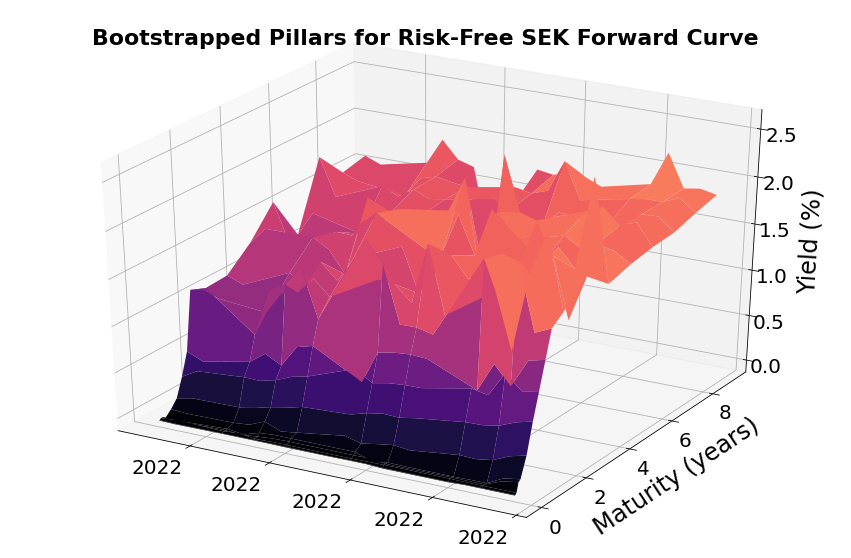

In [ ]:
# @title Plot Risk-Free Surface

## PLOT THE PILLARS FOR ALL THE BOOTSTRAPPED _RISK-FREE_ CURVES 
import numpy as np
import datetime
import matplotlib.dates as dates
import matplotlib.ticker as ticker
#from google.colab import files
# Plot with pillars and interpolation
def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
XL_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=XL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=XL_SIZE)  # fontsize of the figure title

valuation_dates_datetime = []
for dt in valuation_dates:
  valuation_dates_datetime.append(ql_to_datetime(dt))

x_data = []
y_data = []
z_data = []
i = 0
X = N_dates
for dt in valuation_dates_datetime:
    dt_num = dates.date2num(dt)
    x_row = []
    y_row = []
    z_row = []
    for j in range(0,len(ois_year_fracs_pillarss[i])): # only pillars
      x_row.append(dt_num)
      z_row.append(ois_f_pillarss[i][j]*100)
    x_data.append(x_row)
    y_data.append(ois_year_fracs_pillarss[i]) # only pillars
    z_data.append(z_row)
    i = i + 1

# Converting lists to np.arrays
x = np.array(x_data, dtype='f') # x ==> Dates
y = np.array(y_data, dtype='f') # y ==> Maturities
z = np.array(z_data, dtype='f') # z ==> Yields

fig = plt.figure(figsize=(15, 10)) 
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, rstride=2, cstride=1, cmap='magma', vmin=np.nanmin(z), vmax=np.nanmax(z)) # SEK
#ax.plot_surface(x, y, z, rstride=2, cstride=1, cmap='viridis', vmin=np.nanmin(z), vmax=np.nanmax(z)) # EUR
ax.set_title('Bootstrapped Pillars for Risk-Free '+currency+' Forward Curve', fontweight="bold")
ax.set_ylabel('\nMaturity (years)')
ax.set_zlabel('\nYield (%)')
#ax.view_init(30, 280) # Rotation of figure

def format_date(x, pos=None):
     return dates.num2date(x).strftime('%Y')
ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
for tl in ax.w_xaxis.get_ticklabels():
    tl.set_ha('right')
    tl.set_rotation(0)
    #tl.set_rotation(40) # Rotation of Year labels


# To save file in EPS-format:
#plt.savefig('AllDatesBootstrappedPillars'+currency+'riskfree.eps', format='eps', bbox_inches='tight')
#files.download('AllDatesBootstrappedPillars'+currency+'riskfree.eps') 

#plt.savefig('fig-all_tenor_curves_pillars.png')
plt.show()

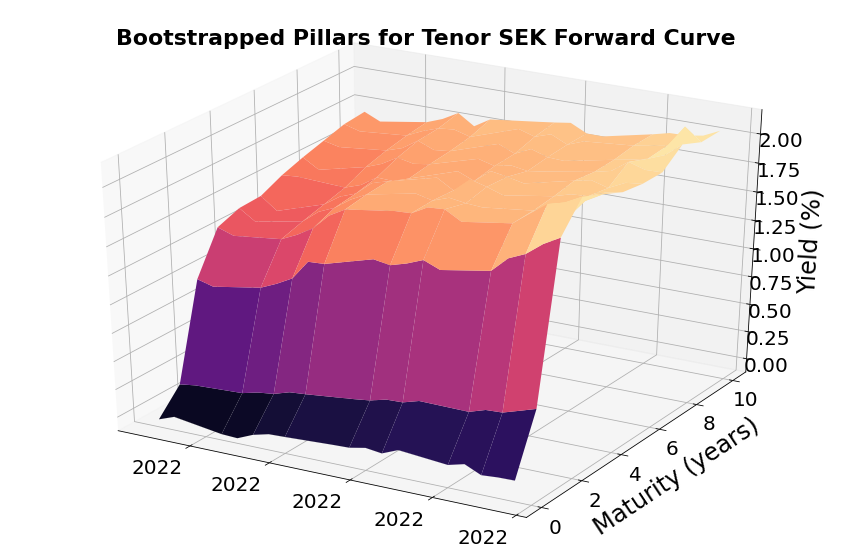

In [ ]:
# @title Plot Tenor Surface

## PLOT THE PILLARS FOR ALL THE BOOTSTRAPPED _TENOR_ CURVES 
import numpy as np
import datetime
import matplotlib.dates as dates
import matplotlib.ticker as ticker
#from google.colab import files
# Plot with pillars and interpolation
def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
XL_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=XL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=XL_SIZE)  # fontsize of the figure title

valuation_dates_datetime = []
for dt in valuation_dates:
  valuation_dates_datetime.append(ql_to_datetime(dt))

x_data = []
y_data = []
z_data = []
i = 0
X = N_dates
for dt in valuation_dates_datetime:
    dt_num = dates.date2num(dt)
    x_row = []
    y_row = []
    z_row = []
    for j in range(0,len(tenor_fwdPillarss[i])): # only pillars
      x_row.append(dt_num)
      z_row.append(tenor_fwdPillarss[i][j]*100)
    x_data.append(x_row)
    y_data.append(tenor_year_fracs_pillarss[i]) # only pillars
    z_data.append(z_row) 
    i = i + 1

# Converting lists to np.arrays
x = np.array(x_data, dtype='f') # x ==> Dates
y = np.array(y_data, dtype='f') # y ==> Maturities
z = np.array(z_data, dtype='f') # z ==> Yields

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
if currency == 'SEK':
    ax.plot_surface(x, y, z, rstride=2, cstride=1, cmap='magma', vmin=np.nanmin(z), vmax=np.nanmax(z)) # SEK
if currency == 'EUR':
    ax.plot_surface(x, y, z, rstride=2, cstride=1, cmap='viridis', vmin=np.nanmin(z), vmax=np.nanmax(z)) # EUR
ax.set_title('Bootstrapped Pillars for Tenor '+currency+' Forward Curve', fontweight="bold")
ax.set_ylabel('\nMaturity (years)')
ax.set_zlabel('\nYield (%)')
#ax.view_init(30, 280) # Rotation of figure

def format_date(x, pos=None):
     return dates.num2date(x).strftime('%Y')
ax.w_xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
for tl in ax.w_xaxis.get_ticklabels():
    tl.set_ha('right')
    tl.set_rotation(0)
    #tl.set_rotation(40) # Rotation of Year labels


# To save file in EPS-format (de-comment below!):
#plt.savefig('AllDatesBootstrappedPillars'+currency+'tenor.eps', format='eps', bbox_inches='tight')
#files.download('AllDatesBootstrappedPillars'+currency+'tenor.eps') 

#plt.savefig('fig-all_tenor_curves_pillars.png')
plt.show()

March 25th, 2022   Multiplecurve interpolated.


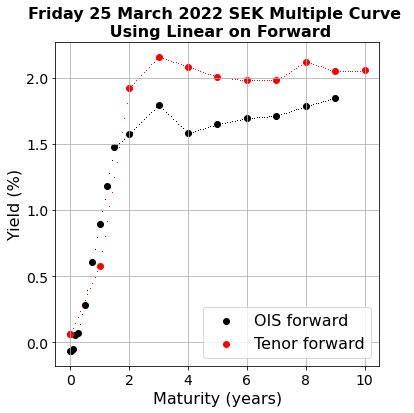

March 24th, 2022   Multiplecurve interpolated.
March 23rd, 2022   Multiplecurve interpolated.
March 22nd, 2022   Multiplecurve interpolated.
March 21st, 2022   Multiplecurve interpolated.
March 18th, 2022   Multiplecurve interpolated.
March 17th, 2022   Multiplecurve interpolated.
March 16th, 2022   Multiplecurve interpolated.
March 15th, 2022   Multiplecurve interpolated.
March 14th, 2022   Multiplecurve interpolated.
March 11th, 2022   Multiplecurve interpolated.
March 10th, 2022   Multiplecurve interpolated.
March 9th, 2022   Multiplecurve interpolated.
March 8th, 2022   Multiplecurve interpolated.
March 7th, 2022   Multiplecurve interpolated.
March 4th, 2022   Multiplecurve interpolated.


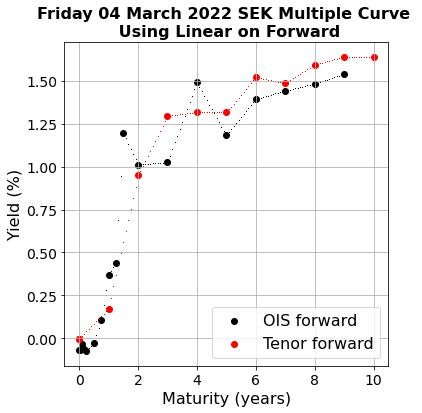

March 3rd, 2022   Multiplecurve interpolated.


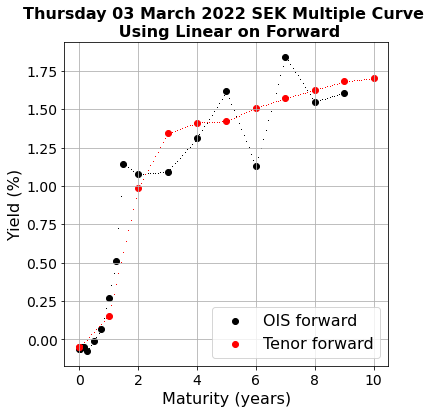

In [ ]:
# @title Interpolate Multiple Curve

## INTERPOLATE Multiple Curve
from scipy import interpolate
import datetime
      

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
XL_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


ipol_f_ois_datass = []
ipol_f_tenor_datass = []

for i in range(0,N_dates):
  # Create daily schedule for OIS rates 
  ois_dates = ois_datess[i]
  ois_schedule = ql.MakeSchedule(
      ois_dates[0], ois_dates[len(ois_dates)-1], ql.Period('1D'), rule=ql.DateGeneration.Forward)

  # Create OIS year fractions for all relevant days
  ois_year_fracs_ipol = [] 
  ois_year_fracs_ipol = [fracConvention.yearFraction(ois_dates[0], t) for
                        t in ois_schedule]

  # Create daily schedule for Tenor rates 
  tenor_dates = tenor_datess[i]
  tenor_schedule = ql.MakeSchedule(
      tenor_dates[0], tenor_dates[len(tenor_dates)-1], ql.Period('1D'), rule=ql.DateGeneration.Forward)
   
  # Create Tenor year fractions for all relevant days
  tenor_year_fracs_ipol = []
  tenor_year_fracs_ipol = [fracConvention.yearFraction(tenor_dates[0], t) for
                        t in tenor_schedule]

  # #######################################################################################
  # VAL AV INTERPOLATIONSMETOD _MULTIPEL_ KURVA:   Kommentera bort alla andra som ej används. 
  # #######################################################################################
  #
  # -- Metoder från QuantLib:
  #
  # Linear:
  ipol_method_ois_f = ql.LinearInterpolation(ois_year_fracs_pillarss[i], ois_f_pillarss[i]); IMF_ois = "Linear on Forward"             
  ipol_method_tenor_f = ql.LinearInterpolation(tenor_year_fracs_pillarss[i], tenor_fwdPillarss[i]); IMF = "Linear on Forward"                 
  #
  # NC Spline:
  #ipol_method_ois_f = ql.CubicNaturalSpline(ois_year_fracs_pillarss[i], ois_f_pillarss[i]); IMF_ois = "Natural Cubic Spline on Forward" 
  #ipol_method_tenor_f = ql.CubicNaturalSpline(tenor_year_fracs_pillarss[i], tenor_fwdPillarss[i]); IMF = "Natural Cubic Spline on Forward"                     
  #
  #         OBS! Below two rows are needed for all QuantLib methods, for Spot and/or Forward respectively
  #
  ipol_data_f_ois = [ipol_method_ois_f(x, allowExtrapolation=True) for x in ois_year_fracs_ipol] # FORWARD
  ipol_data_f_tenor = [ipol_method_tenor_f(x, allowExtrapolation=True) for x in tenor_year_fracs_ipol] # FORWARD
  #
  #
  # -- Metoder från Scipy:                                                      
  #
  # Q Spline:                                                                             #, fill_value='extrapolate') # can be added below to quadratic
  #ipol_method_ois_f = interpolate.interp1d(ois_year_fracs_pillarss[i], ois_f_pillarss[i], kind='quadratic', fill_value='extrapolate'); IMF_ois = "Quadratic Spline on Forward"     
  #ipol_method_tenor_f = interpolate.interp1d(tenor_year_fracs_pillarss[i], tenor_fwdPillarss[i], kind='quadratic', fill_value='extrapolate'); IMF = "Quadratic Spline on Forward"   
  #
  #         OBS! Below two rows are needed for all Scipy methods, for Spot and/or Forward respectively
  #
  #ipol_data_f_ois = [ipol_method_ois_f(x) for x in ois_year_fracs_ipol] # FORWARD 
  #ipol_data_f_tenor = [ipol_method_tenor_f(x) for x in tenor_year_fracs_ipol] # FORWARD 
  #
  #
  #
  #########################################################################################
  ipol_f_ois_datass.append(ipol_data_f_ois)
  ipol_f_tenor_datass.append(ipol_data_f_tenor)
  print(valuation_dates[i], "\f \f Multiplecurve interpolated.")

  if i == 0 or i == (N_dates - 2) or (i == N_dates - 1): # Draw first and last two dates
  #if True: # Draw all dates
    # PLOT CURVES
    fig3 = plt.figure(figsize=(6,6))
    ax = fig3.add_axes([0.15,0.15,0.75,0.75])

    # OIS forward curve
    plt.scatter(ois_year_fracs_ipol, [ipol_data_f_ois[i]*100 for i in range(0,len(ipol_data_f_ois))], s=1, color='k', marker="s", linewidth=0) # EUR INTERPOLATION
    plt.scatter(ois_year_fracs_pillarss[i], [ois_f_pillarss[i][j]*100 for j in range(0,len(ois_f_pillarss[i]))], color='k', label='OIS forward') # PILLARS
  
    # TENOR forward curve 
    if currency == "SEK":
    # SEK:
      plt.scatter(tenor_year_fracs_ipol, [ipol_data_f_tenor[i]*100 for i in range(0,len(ipol_data_f_tenor))], s=1, color='r', marker="s", linewidth=0) # INTERPOLATION
      plt.scatter(tenor_year_fracs_pillarss[i], [tenor_fwdPillarss[i][j]*100 for j in range(0,len(tenor_fwdPillarss[i]))], color='r', label='Tenor forward') # PILLARS
    elif currency == "EUR":
    # EUR:
      plt.scatter(tenor_year_fracs_ipol, [ipol_data_f_tenor[i]*100 for i in range(0,len(ipol_data_f_tenor))], s=1, color='b', marker="s", linewidth=0) # INTERPOLATION
      plt.scatter(tenor_year_fracs_pillarss[i], [tenor_fwdPillarss[i][j]*100 for j in range(0,len(tenor_fwdPillarss[i]))], color='b', label='Tenor forward') # PILLARS
    zoom = ''
    #plt.axis([0, 5, -1.0, 1.]); zoom = " zoomed-in short-end < 5Y" # Comment this line for no zoom
    #plt.axis([0, 1, -1.0, 1.]); zoom = " zoomed-in short-end < 1Y" # Comment this line for no zoom
    ax.set_xlabel('Maturity (years)')
    ax.set_ylabel('Yield (%)')
    def ql_to_datetime(d):
      return datetime.datetime(d.year(), d.month(), d.dayOfMonth())
    ax.set_title(ql_to_datetime(valuation_dates[i]).strftime("%A %d %B %Y")+' '+currency+' Multiple Curve \n Using '+IMF+zoom, fontname="Times New Roman",fontweight="bold")
    plt.legend(title='')
    plt.grid()
    #plt.grid(axis = 'x')
  
    # To save file in EPS-format (un-comment below!):
    str_date = ql_to_datetime(valuation_dates[i]).strftime("%d%m%Y")
    str_type = IMF.replace(" ", "")
    FileName = 'Ipol-'+str_date+'-'+str_type+currency+'.eps'
    #plt.savefig(FileName, format='eps')
    #files.download(FileName) 
    #print(FileName, " was saved.")
    plt.show()

In [ ]:
# @title Leave-One-Out

In [ ]:
# Interpolate OIS curves for the leave-one-out method

from scipy import interpolate
import copy as cp
LOO_start_ois = 1
LOO_end_ois = len(OIS_tenors)-1
error_ois_datas = []

N = N_dates
for X in range(0,N):
  error_ois_data = []
  error_ois_data = []
  for j in range(LOO_start_ois,LOO_end_ois):
    ois_year_fracs_pillars = cp.copy(ois_year_fracs_pillarss[X])
    ois_year_fracs_pillars.pop(j)
    ois_pillars = cp.copy(ois_pillarss[X])
    ois_pillars.pop(j)
    # #######################################################################################
    # Choice of interpolation method for the OIS curve. Uncomment the ones not in use.
    # #######################################################################################
    #
    # Methods from QuantLib:
    #ipol_method_ois = ql.LinearInterpolation(ois_year_fracs_pillars, ois_pillars); IMS_ois = "Linear on Spot"                 # Linear on Spot
    #ipol_method_ois = ql.CubicNaturalSpline(ois_year_fracs_pillars, ois_pillars); IMS_ois = "Natural Cubic Spline on Spot"    # Natural Cubic Spline on Spot
    #
    # OBS! Below row are needed for all QuantLib methods, for Spot and/or Forward respectively
    #
    #error_ois_data.append(ipol_method_ois(ois_year_fracs_pillarss[X][j], allowExtrapolation=True)) # SPOT
    #
    #
    # Methods from Scipy:                                                    
    #                                                                             #, fill_value='extrapolate') # can be added below to quadratic
    ipol_method_ois = interpolate.interp1d(ois_year_fracs_pillars, ois_pillars, kind='quadratic', fill_value='extrapolate'); IMS_ois = "Quadratic Spline on Spot"    # Quadratic Spline on Spot
    #
    # OBS! Below row are needed for all Scipy methods, for Spot and/or Forward respectively
    #
    error_ois_data.append(ipol_method_ois(ois_year_fracs_pillarss[X][j]).tolist()) # SPOT
    #
    #
    #
    #########################################################################################
  error_ois_datas.append(error_ois_data) # save per date X
 
  print(valuation_dates[X], "\f \f OIS curve LOO:ed and interpolated.")

March 25th, 2022   OIS curve LOO:ed and interpolated.
March 24th, 2022   OIS curve LOO:ed and interpolated.
March 23rd, 2022   OIS curve LOO:ed and interpolated.
March 22nd, 2022   OIS curve LOO:ed and interpolated.
March 21st, 2022   OIS curve LOO:ed and interpolated.
March 18th, 2022   OIS curve LOO:ed and interpolated.
March 17th, 2022   OIS curve LOO:ed and interpolated.
March 16th, 2022   OIS curve LOO:ed and interpolated.
March 15th, 2022   OIS curve LOO:ed and interpolated.
March 14th, 2022   OIS curve LOO:ed and interpolated.
March 11th, 2022   OIS curve LOO:ed and interpolated.
March 10th, 2022   OIS curve LOO:ed and interpolated.
March 9th, 2022   OIS curve LOO:ed and interpolated.
March 8th, 2022   OIS curve LOO:ed and interpolated.
March 7th, 2022   OIS curve LOO:ed and interpolated.
March 4th, 2022   OIS curve LOO:ed and interpolated.
March 3rd, 2022   OIS curve LOO:ed and interpolated.


In [ ]:
# Interpolate tenor curves for the leave-one-out method

from scipy import interpolate
import copy as cp

# BELOW ONLY FOR CONTROL ***
ipol_datass = []
ipol_datass_f = []
year_fracss_ipol = [] 
# ABOVE ONLY FOR CONTROL *** 

LOO_start_tenor = 1
LOO_end_tenor = len(tenors)-1
error_tenor_datas = []
error_tenor_f_datas = []      

N = N_dates 
for X in range(0,N): 
  error_tenor_data = []
  error_tenor_f_data = [] 
  tenor_dates = tenor_datess[X]

  ipol_datas = []
  ipol_datas_f = []
  for j in range(LOO_start_tenor,LOO_end_tenor):
    tenor_year_fracs_pillars = cp.copy(tenor_year_fracs_pillarss[X])
    tenor_year_fracs_pillars.pop(j)
    tenor_pillars = cp.copy(tenor_pillarss[X])
    tenor_pillars.pop(j)
    tenor_fwdPillars = cp.copy(tenor_fwdPillarss[X])
    tenor_fwdPillars.pop(j)

    # #######################################################################################
    # Choice of interpolation method for the tenor curve. Uncomment the ones not in use.
    # #######################################################################################
    #
    # Methods from QuantLib:
    #
    #ipol_method = ql.LinearInterpolation(tenor_year_fracs_pillars, tenor_pillars); IMS = "Linear on Spot"                                   # Linear on Spot
    #ipol_method_f = ql.LinearInterpolation(tenor_year_fracs_pillars, tenor_fwdPillars); IMF = "Linear on Forward"                            # Linear on Forward
    #ipol_method = ql.CubicNaturalSpline(tenor_year_fracs_pillars, tenor_pillars); IMS = "Natural Cubic Spline on Spot"                       # Natural Cubic Spline on Spot
    #ipol_method_f = ql.CubicNaturalSpline(tenor_year_fracs_pillars, tenor_fwdPillars); IMF = "Natural Cubic Spline on Forward"                            # Linear on Forward
    #
    # OBS! Below two rows are needed for all QuantLib methods, for Spot and/or Forward respectively
    #
    #
    #error_tenor_data.append(ipol_method(tenor_year_fracs_pillarss[X][j], allowExtrapolation=True)) # SPOT
    #error_tenor_f_data.append(ipol_method_f(tenor_year_fracs_pillarss[X][j], allowExtrapolation=True)) # SPOT
    #
    # Methods from Scipy:                                                      
    #                                                                             #, fill_value='extrapolate') # can be added below to quadratic
    ipol_method = interpolate.interp1d(tenor_year_fracs_pillars, tenor_pillars, kind='quadratic', fill_value='extrapolate'); IMS = "Quadratic Spline on Spot"         # Quadratic Spline on Spot
    ipol_method_f = interpolate.interp1d(tenor_year_fracs_pillars, tenor_fwdPillars, kind='quadratic', fill_value='extrapolate'); IMF = "Quadratic Spline on Forward"  # Quadratic Spline on Forward
    #
    # OBS! Below two rows are needed for all Scipy methods, for Spot and/or Forward respectively
    #
    error_tenor_data.append(ipol_method(tenor_year_fracs_pillarss[X][j]).tolist()) # SPOT
    error_tenor_f_data.append(ipol_method_f(tenor_year_fracs_pillarss[X][j]).tolist()) # SPOT
    #
    #
    #
    #
    #########################################################################################


  error_tenor_datas.append(error_tenor_data) # Save per date X
  error_tenor_f_datas.append(error_tenor_f_data) # Save per date X

  ipol_datass.append(ipol_datas) # Save per date X
  ipol_datass_f.append(ipol_datas_f) # Save per date X

  print(valuation_dates[X], "\f \f Tenor curve LOO:ed and interpolated.")

March 25th, 2022   Tenor curve LOO:ed and interpolated.
March 24th, 2022   Tenor curve LOO:ed and interpolated.
March 23rd, 2022   Tenor curve LOO:ed and interpolated.
March 22nd, 2022   Tenor curve LOO:ed and interpolated.
March 21st, 2022   Tenor curve LOO:ed and interpolated.
March 18th, 2022   Tenor curve LOO:ed and interpolated.
March 17th, 2022   Tenor curve LOO:ed and interpolated.
March 16th, 2022   Tenor curve LOO:ed and interpolated.
March 15th, 2022   Tenor curve LOO:ed and interpolated.
March 14th, 2022   Tenor curve LOO:ed and interpolated.
March 11th, 2022   Tenor curve LOO:ed and interpolated.
March 10th, 2022   Tenor curve LOO:ed and interpolated.
March 9th, 2022   Tenor curve LOO:ed and interpolated.
March 8th, 2022   Tenor curve LOO:ed and interpolated.
March 7th, 2022   Tenor curve LOO:ed and interpolated.
March 4th, 2022   Tenor curve LOO:ed and interpolated.
March 3rd, 2022   Tenor curve LOO:ed and interpolated.


In [ ]:
# For obtaining valuation errors - new with loop

control2 = True

# From QuantLib datetime definition to Python datetime

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())
valuation_dates_datetime = []

dX_OISss = []
dX_IRSss = []
N = N_dates
for X in range(0,N):
  valuation_date = valuation_dates[X]
  ql.Settings.instance().evaluationDate = valuation_date

  # For controlling result later:

  OIS_rates = OIS_ratess[X]
  IRS_rates = IRS_ratess[X]
  IBOR_rates = IBOR_ratess[X]
  rates = IBOR_rates+IRS_rates

  # For OIS curve:

  ois_dates = cp.copy(ois_datess[X])
  ois_pillars = cp.copy(ois_pillarss[X])
  #error_ois_data = cp.copy(error_ois_datas[X]) # OIS not implemented!
  
  # For tenor curve:

  tenor_dates = cp.copy(tenor_datess[X])
  tenor_pillars = cp.copy(tenor_pillarss[X])
  tenor_fwdPillars = cp.copy(tenor_fwdPillarss[X])
  error_tenor_data = cp.copy(error_tenor_datas[X])
  error_tenor_f_data = cp.copy(error_tenor_f_datas[X]) 

  # Pad start and end with 0.0 because those pillars haven't been LOO:ed:

  error_tenor_data.insert(0,0)
  error_tenor_data.append(0)
  error_tenor_f_data.insert(0,0)
  error_tenor_f_data.append(0)

  dX_OISs = [ql_to_datetime(valuation_date)]
  dX_IRSs = [ql_to_datetime(valuation_date)]

  # Print IRS:

  if control2: 
    print(valuation_date)
    print("IRS from "+currency+" curve.")
    print(f"{'Maturity':^12}\t{' Pillar rate'}\t{' Quoted rate'}\t{'Rate-pillar '}\t{' Error rate'}\t{' Error-pillar'}")
    print(f"{' '}           \t{' '}           \t{' '}             {'  diff'}      \t{''}           \t{' diff'}")
    print(f"{' '}           \t{' X'}          \t{' X'}            {'  '}          \t{' X^{tilde}_i'}\t{' '}")

  for LOO_Y in range(LOO_start_tenor, LOO_end_tenor):

    # For obtaining errors

    pillar_oisCurve = ql.ZeroCurve(ois_dates, ois_pillars, dayConvention)
    pillar_oisCurve.enableExtrapolation()
    pillar_oisTermStructure = ql.YieldTermStructureHandle(pillar_oisCurve)
    pillar_oisEngine = ql.DiscountingSwapEngine(pillar_oisTermStructure)

    pillar_tenorCurve = ql.ForwardCurve(tenor_dates, tenor_fwdPillars, dayConvention)
    pillar_tenorCurve.enableExtrapolation()
    pillar_tenorTermStructure = ql.YieldTermStructureHandle(pillar_tenorCurve)
    pillar_tenorEngine = ql.DiscountingSwapEngine(pillar_tenorTermStructure)

    # Change the LOO:ed pillar to erroneous value:

    correct_ois_pillars = cp.copy(ois_pillars)
    error_ois_pillars = correct_ois_pillars
    #error_ois_pillars[] # Only change tenor pillars for now! LOO not implemented for OIS
    correct_tenor_pillars = cp.copy(tenor_pillars)
    error_tenor_pillars = correct_tenor_pillars
    error_tenor_pillars[LOO_Y+len(IBOR_tenors)] = error_tenor_data[LOO_Y] # Replace correct pillar with erroneous one!
    correct_tenor_fwdPillars = cp.copy(tenor_fwdPillars)
    error_tenor_fwdPillars = correct_tenor_fwdPillars
    error_tenor_fwdPillars[LOO_Y+len(IBOR_tenors)] = error_tenor_f_data[LOO_Y] # Replace correct pillar with erroneous one!


    # For obtaining errors:

    error_oisCurve = ql.ZeroCurve(ois_dates, error_ois_pillars, dayConvention)
    error_oisCurve.enableExtrapolation()
    error_oisTermStructure = ql.YieldTermStructureHandle(error_oisCurve)
    error_oisEngine = ql.DiscountingSwapEngine(error_oisTermStructure)

    error_tenorCurve = ql.ForwardCurve(tenor_dates, error_tenor_fwdPillars, dayConvention)
    error_tenorCurve.enableExtrapolation()
    error_tenorTermStructure = ql.YieldTermStructureHandle(error_tenorCurve)
    error_tenorEngine = ql.DiscountingSwapEngine(error_tenorTermStructure)
    
    # Pillars:

    if currency == "SEK":
      pillar_overnightIndex = ql.OvernightIndex(ONindex_name, settlementDays,
                                         qlCurrency, calendar, 
                                         dayConvention, pillar_oisTermStructure)
    elif currency == "EUR":
      pillar_overnightIndex = ql.OvernightIndex(ONindex_name, settlementDays,
                                         qlCurrency, calendar, 
                                         dayConvention, pillar_oisTermStructure)

    if currency == "SEK":
      pillar_index = ql.IborIndex(iborIndex_name, ql.Period('3m'), 
                           settlementDays, qlCurrency, 
                           calendar, fixedLegConvention, 
                           True, dayConvention, pillar_tenorTermStructure)

    if currency == "EUR":
      pillar_index = ql.IborIndex(iborIndex_name, ql.Period('6m'), 
                           settlementDays, qlCurrency, 
                           calendar, fixedLegConvention, 
                           True, dayConvention, pillar_tenorTermStructure)
    
    # Errors: 

    if currency == "SEK":
      error_overnightIndex = ql.OvernightIndex(ONindex_name, settlementDays,
                                         qlCurrency, calendar, 
                                         dayConvention, error_oisTermStructure)
    elif currency == "EUR":
      error_overnightIndex = ql.OvernightIndex(ONindex_name, settlementDays,
                                         qlCurrency, calendar, 
                                         dayConvention, error_oisTermStructure)

    if currency == "SEK":
      error_index = ql.IborIndex(iborIndex_name, ql.Period('3m'), 
                           settlementDays, qlCurrency, 
                           calendar, fixedLegConvention, 
                           True, dayConvention, error_tenorTermStructure)

    if currency == "EUR":
      error_index = ql.IborIndex(iborIndex_name, ql.Period('6m'), 
                           settlementDays, qlCurrency, 
                           calendar, fixedLegConvention, 
                           True, dayConvention, error_tenorTermStructure)

    if True:
        fixedRate = 0 # Can be set to zero since we are calculating the fair rate (solving for the fixed rate)
        pillar_ois = ql.MakeOIS(ql.Period(tenor), pillar_overnightIndex, 
                         fixedRate, pricingEngine=pillar_oisEngine)
        error_ois = ql.MakeOIS(ql.Period(tenor), error_overnightIndex, 
                         fixedRate, pricingEngine=error_oisEngine)
        
        dX_OIS = error_ois.fairRate() - pillar_ois.fairRate()
        dX_OISs.append(dX_OIS)

    # swapTenor is the tenor from each IRS_tenors
    pillar_iborIndex = pillar_index
    error_iborIndex = error_index
    fixedRate = 0 
    forwardStart = ql.Period('0D') 

    if True:
      tenor = tenors[LOO_Y]
      rate = rates[LOO_Y]
      pillar_swap = ql.MakeVanillaSwap(ql.Period(tenor), pillar_iborIndex,
                                fixedRate, forwardStart,  
                                pricingEngine=pillar_tenorEngine)     
      error_swap = ql.MakeVanillaSwap(ql.Period(tenor), error_iborIndex,
                                fixedRate, forwardStart,  
                                pricingEngine=error_tenorEngine)        
      if control2:
        print(f"{tenor:^12}\t{unit*pillar_swap.fairRate(): 0.6f} bp\t{unit*rate: 0.6f} bp \t{unit*abs(rate - pillar_swap.fairRate() ): 0.6f} bp\t{unit*error_swap.fairRate(): 0.6f} bp \t{unit*abs(error_swap.fairRate() - pillar_swap.fairRate() ): 0.6f} bp")
 
    if True:
      dX_IRS = error_swap.fairRate() - pillar_swap.fairRate() 
      dX_IRSs.append(dX_IRS)
   
    # Save the erros in DataFrames:

  dX_OISss.append(dX_OISs)
  dX_IRSss.append(dX_IRSs)

  print(valuation_date, " done. \n")

#dX_OIS_df = pd.DataFrame(dX_OISss, columns = ["Valuation date \ Maturity "]+OIS_tenors)
dX_IRS_df = pd.DataFrame(dX_IRSss, columns = ["Valuation date \ Maturity "]+tenors[LOO_start_tenor:LOO_end_tenor])
dX_OIS_df = cp.copy(dX_IRS_df) # not used anyways

dX_dfs = []
dX_dfs.append(dX_OIS_df)
dX_dfs.append(dX_IRS_df)
print("Valuation errors for "+IMS+" and "+IMF+" have been calculated. Done.")

March 25th, 2022
IRS from SEK curve.
  Maturity  	 Pillar rate	 Quoted rate	Rate-pillar 	 Error rate	 Error-pillar
            	            	                diff      	           	 diff
            	 X          	 X                        	 X^{tilde}_i	 
     1Y     	 59.000000 bp	 59.000000 bp 	 0.000000 bp	 6.634467 bp 	 52.365533 bp
     2Y     	 127.400000 bp	 127.400000 bp 	 0.000000 bp	 72.025994 bp 	 55.374006 bp
     3Y     	 158.300000 bp	 158.300000 bp 	 0.000000 bp	 136.282973 bp 	 22.017027 bp
     4Y     	 171.500000 bp	 171.500000 bp 	 0.000000 bp	 176.588737 bp 	 5.088737 bp
     5Y     	 178.000000 bp	 178.000000 bp 	 0.000000 bp	 179.729244 bp 	 1.729244 bp
     6Y     	 182.000000 bp	 182.000000 bp 	 0.000000 bp	 182.644848 bp 	 0.644848 bp
     7Y     	 184.800000 bp	 184.800000 bp 	 0.000000 bp	 184.319860 bp 	 0.480140 bp
     8Y     	 188.600000 bp	 188.600000 bp 	 0.000000 bp	 187.892169 bp 	 0.707831 bp
     9Y     	 190.800000 bp	 190.800000 bp 	 0.000000 bp	 19

In [ ]:
## RESULT: Leave-one-out valuation errors to Excel

dX_dfs[1].to_excel("priceErrors"+currency+IMF.replace(" ","_")+".xlsx",
             sheet_name='Errors') 